In [3]:
import json
import os
import re
import sys
import warnings

import cv2
import imageio
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from PIL import Image, ImageFilter
from sklearn import decomposition
from sklearn.preprocessing import PolynomialFeatures, normalize
from sklearn.linear_model import LogisticRegression
from scipy.misc import imresize
from skimage import feature, color
%matplotlib inline

# Hide scikit-learn warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def file_list(start_dir):
    """Generate file list in directory"""
    file_list = []
    for root, dirs, files in os.walk(start_dir):
        for f in files:
            if f[0] != '.':
                file_list.append(f)
    return file_list

def hog_img(img):
    """Generate Histogram of Oriented Gradients for image"""
    # img = np.asarray(img)
    hogged, hogged_img = feature.hog(color.rgb2gray(img), visualise=True)
    return hogged

def img2features(img):
    return hog_img(img)

def scene_detection(positive_path, negative_path):
    """Train scene detection classifier"""

    # Print status
    print('Training scene detection classifier')

    # Build training set of classified images
    positive_list = file_list(positive_path)
    negative_list = file_list(negative_path)
    X = []
    y = []

    for f in positive_list:
        img = np.array(Image.open(os.path.join(positive_path, f)))
        X.append(img2features(img))
        y.append(1)

    for f in negative_list:
        img = np.array(Image.open(os.path.join(negative_path, f)))
        X.append(img2features(img))
        y.append(0)

    # PCA to get valuable features
    pca = decomposition.PCA(n_components=4)
    pca.fit(X)
    X = pca.transform(X)

    # Train model
    model = LogisticRegression()
    model.fit(X, y)

    return (model, pca)

def get_health_status(img, **kwargs):
    # Player status
    h, w, c = img.shape
    factor = 0.226
    y1 = int(h * 0.044)
    x1 = int(w * (0.5 - factor))
    y2 = y1+1
    x2 = int(w * (0.5 + factor))
    pl_status = img[y1:y2, x1:x2, :]

    # Block out center of player status
    h, w, c = pl_status.shape
    factor = .12
    x1 = int(np.round(w * (0.5 - factor)))+1
    x2 = int(np.round(w * (0.5 + factor)))
    pl_status[:, x1:x2, :] = 0

    pl_status = pl_status[:,:,::-1] # Put player status from RGB to BGR for OpenCV
    hsv = cv2.cvtColor(pl_status,cv2.COLOR_BGR2HSV)
    h = cv2.calcHist([hsv], [0], None, [256], [0,256])
    s = cv2.calcHist([hsv], [1], None, [256], [0,256])
    v = cv2.calcHist([hsv], [2], None, [256], [0,256])

    # Initialize colors
    red = int(sum(h[1:15]))
    green = int(sum(h[50:65]))
    if red == 0 or green == 0:
        return (0, 0)
    # else:
    #     # Save image for validation
    #     basepath = '/Volumes/Passport/LiveBeat/'
    #     save_path = os.path.join(basepath, 'validation', '{}.png'.format(i))
    #     Image.fromarray(pl_status).save(save_path)
    return (red, green)

def segmenter(video_path, model, pca, threshold=0.5, seconds_between_frames=60):
    """Generate timecodes for game and non-game segments"""

    # Print status
    print('Finding timecodes for segments')

    # Open file handle
    vid = imageio.get_reader(video_path, 'ffmpeg')

    # Get metadata and select 1 frame every n seconds
    meta = vid.get_meta_data()
    fps = int(np.round(meta['fps']))
    nframes = meta['nframes']
    frames = np.arange(0, nframes, seconds_between_frames*fps)

    # Check frames
    timecodes = []
    statuses = []
    start_time = end_time = 0
    segment = 1
    switch = False
    
    # Run through frames and find segments
    for i in frames:
        img = vid.get_data(i)

        # Resize image appropriately for training set
        img = imresize(img, (720, 1280))

        # Isolate shop button
        h, w, c = img.shape
        x1 = int(w * .94)
        x2 = x1 + 76
        y1 = int(h * .814)
        y2 = y1 + 26
        shop = img[y1:y2, x1:x2, :]

        # Get player status
        red, green = get_health_status(img, i=i)

        # Generate predictions for each selected frame
        features = pca.transform(img2features(shop))
        features = np.array(features).reshape(1, -1)
        prediction = model.predict(features)

        second = int(i/fps)
        if prediction >= threshold:
            switch = True
            statuses.append([second, red, green, segment])
        else:
            if switch:
                segment += 1
            switch = False
            statuses.append([second, 0, 0, 0])

    # Close video handle to release thread and buffer
    vid.close()

    # Process status results and filter out short sections
    for i in range(1, len(statuses)-3):
        if (statuses[i][3] == 1
            and statuses[i-1][3] == 0
            and statuses[i+2][3] == 0):
            statuses[i][1:] = (0, 0, 0)
            statuses[i+1][1:] = (0, 0, 0)

    status = pd.DataFrame(statuses)
    status.columns = ['second', 'red', 'green', 'game']

    # status.to_csv('/Users/Rich/Documents/Twitch/statuses/color_hist_check.csv')
    #
    # red_threshold = status['red'].mean() + 3*status['red'].std()
    # status.loc[
    #         status['red'] > red_threshold, 'red'
    # ] = status['red'].median()
    #
    # green_threshold = status['green'].mean() + 3*status['green'].std()
    # status.loc[
    #         status['green'] > red_threshold, 'green'
    # ] = status['green'].median()

    red_max = status['red'].max()
    green_max = status['green'].max()
    status['red'] = status['red'].apply(
            lambda x: x/red_max
    ).round(2)
    status['green'] = status['green'].apply(
            lambda x: -1*x/green_max
    ).round(2)

    return status

def query_to_video(query):
    video_id = re.findall('\/(\d+)', query)[0]
    return video_id

def compile_chat(chat_path, seconds_per_bin=60):
    def agg_chat(data):
        """Aggregate JSON chat data into a row"""
        attr = data['attributes']

        timestamp = attr['timestamp']
        message = attr['message']
        author = attr['from']
        turbo = attr['tags']['turbo']
        sub = attr['tags']['subscriber']

        try:
            emotes = attr['tags']['emotes']
            emote_count = sum([len(emotes[key]) for key in emotes.keys()])
        except:
            emote_count = 0

        row = {
            'timestamp': timestamp,
            'author': author,
            'message': message,
            'turbo': turbo,
            'sub': sub,
            'emote_count': emote_count
        }

        return row

    # Aggregate files into dictionary
    aggregated = []
    for f in file_list(chat_path):
        get_path = os.path.join(chat_path, f)
        with open(get_path) as c:

            # Format line and separate multiple JSON strings with commas
            line = '[{}]'.format(c.readline()).replace('}}{', '}},{')
            data = json.loads(line)[0]

            for message in data['data']:
                result = agg_chat(message)
                if result['emote_count'] == 0:
                    aggregated.append(result)
                else:
                    aggregated.append(result)
#                     pass

    # Build data frame from chat results
    df = pd.DataFrame(aggregated)
    minimum = df['timestamp'].min()
    maximum = df['timestamp'].max()
    df['timestamp'] = df['timestamp'].apply(lambda x: x - minimum)
    df['secondstamp'] = df['timestamp'].apply(
        lambda x: int(round(x/1000/seconds_per_bin)*seconds_per_bin)
    )
    
    return df
    
    # Create chat frequency data frame where index is no. of seconds into video
    chat_freq = pd.DataFrame(df['secondstamp'].value_counts().sort_index())
    chat_freq.columns = ['frequency']

    # Normalize frequency for plotting
    _max = chat_freq['frequency'].max()
    _min = chat_freq['frequency'].min()
    chat_freq['frequency'] = chat_freq['frequency'].apply(
        lambda x: (x - _min) / (_max - _min)
    )

    # chat_freq.to_csv('/Users/Rich/Documents/Twitch/chat_scale/test.csv')

    return chat_freq

def process_audio(audio_path, integral_window=60):
    # Read wave file and combine to 1 mono channel
    sample_freq, audio = wavfile.read(audio_path)
    channel = audio.mean(axis=1)

    # Integrate over selected interval windows
    integral = []
    for i in np.arange(0, len(channel), integral_window*sample_freq):
        integral.append(
            sum(abs(channel[i:i+integral_window*sample_freq]))
        )

    # Min/max normalize result
    integral = [(v - min(integral))/max(integral) for v in integral]

    return integral

def go():
    # Define basepath for file locations
    basepath = '/Volumes/Passport/LiveBeat/'
    # basepath = '/Users/Rich/Documents/Twitch'

    # Process query to identify video of request and get media paths
    query = request.form['query']
    video_id = query_to_video(query)

    # Generate file paths
    video_file = 'dota2ti_v{}_720p30.mp4'.format(video_id)
    video_path = os.path.join(basepath, 'video', video_file)
    chat_path = os.path.join(basepath, 'chat', 'v{}'.format(video_id))
    audio_path = os.path.join(basepath, 'audio', 'a{}.wav'.format(video_id))

    # Get chat data
    chat = compile_chat(chat_path)

    # Get audio data
    graph_audio = process_audio(audio_path)

    # Get scene detector and acquire game timecodes
    positive_path = os.path.join(basepath, 'test_images_button')
    negative_path = os.path.join(basepath, 'test_images_non-button')
    model, pca = scene_detection(positive_path, negative_path)

    status = segmenter(video_path, model, pca)
    # status.to_csv('/Users/Rich/Documents/Twitch/statuses/test_value.csv')
    # game = TEMP_HAVE_STAMPS(video_id)

    # Build image for scrub plot
    # basepath = '/Users/Rich/Documents/Flask/flaskexample/static/graphs'
    # target_path = os.path.join(basepath, '{}.png'.format(video_id))

    # Extract features to generate graphs
    graph_x = ','.join(status['second'].values.astype(str).tolist())
    graph_red = ','.join(status['red'].values.astype(str).tolist())
    graph_green = ','.join(status['green'].values.astype(str).tolist())
    graph_chat = ','.join(chat['frequency'].values.astype(str).tolist())
    # graph_audio = ','.join(graph_audio)


In [4]:
# Define basepath for file locations
basepath = '/Volumes/Passport/LiveBeat/'
# basepath = '/Users/Rich/Documents/Twitch'

# Process query to identify video of request and get media paths
video_id = '83196893'

# Generate file paths
video_file = 'dota2ti_v{}_720p30.mp4'.format(video_id)
video_path = os.path.join(basepath, 'video', video_file)
chat_path = os.path.join(basepath, 'chat', 'v{}'.format(video_id))
audio_path = os.path.join(basepath, 'audio', 'a{}.wav'.format(video_id))

# Get chat data
chat = compile_chat(chat_path)

# # Get scene detector and acquire game timecodes
# positive_path = os.path.join(basepath, 'test_images_button')
# negative_path = os.path.join(basepath, 'test_images_non-button')
# model, pca = scene_detection(positive_path, negative_path)

# status = segmenter(video_path, model, pca)


In [67]:
print(chat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226714 entries, 0 to 226713
Data columns (total 7 columns):
author         226714 non-null object
emote_count    226714 non-null int64
message        226714 non-null object
sub            226714 non-null bool
timestamp      226714 non-null int64
turbo          226714 non-null bool
secondstamp    226714 non-null int64
dtypes: bool(2), int64(3), object(2)
memory usage: 9.1+ MB
None


(0, 1400)

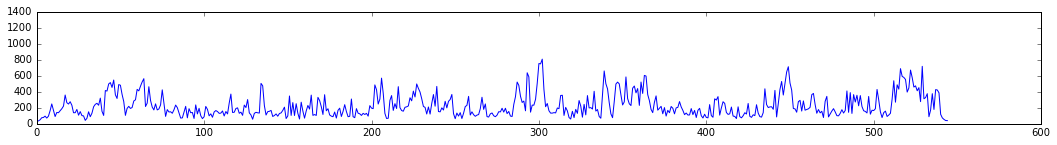

In [17]:
no_emotes = chat.loc[chat['emote_count'] == 0, ['emote_count', 'secondstamp', 'timestamp']]
plt.figure(figsize=(18,2))
plt.plot(no_emotes['secondstamp'].value_counts().sort_index().tolist())
plt.ylim([0, 1400])

(0, 1400)

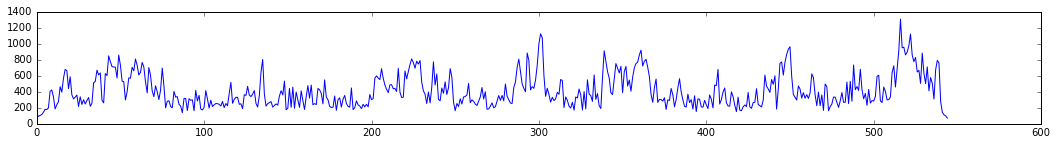

In [19]:
plt.figure(figsize=(18,2))
plt.plot(chat['secondstamp'].value_counts().sort_index().tolist())
plt.ylim([0, 1400])

(0, 1400)

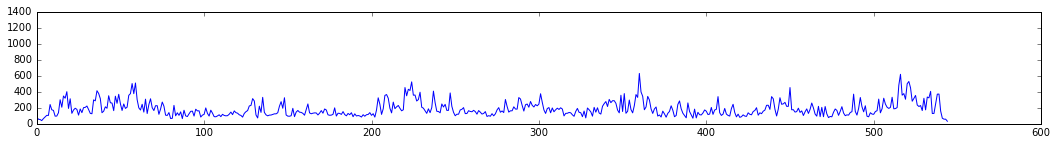

In [18]:
emotes = chat.loc[chat['emote_count'] > 0, ['emote_count', 'secondstamp', 'timestamp']]
plt.figure(figsize=(18,2))
plt.plot(emotes['secondstamp'].value_counts().sort_index().tolist())
plt.ylim([0, 1400])

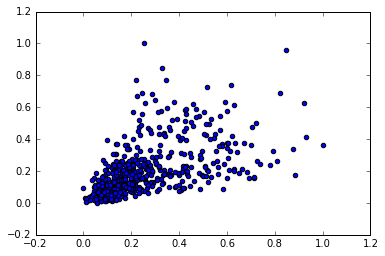

In [55]:
# plt.figure(figsize=(18,2))
# plt.plot(chat.loc[chat['emote_count'] == 5, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist())
# plt.plot(chat.loc[chat['emote_count'] == 4, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist())
# plt.plot(chat.loc[chat['emote_count'] == 3, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist())
# plt.plot(chat.loc[chat['emote_count'] == 2, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist())
emote1 = chat.loc[chat['emote_count'] == 1, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist()
emote0 = chat.loc[chat['emote_count'] == 0, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist()
emoteall = chat.loc[chat['emote_count'] > -1, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist()
emoteall_norm = [(v-min(emoteall))/(max(emoteall)-min(emoteall)) for v in emoteall]
emote0_norm = [(v-min(emote0))/(max(emote0)-min(emote0)) for v in emote0]
emote1_norm = [(v-min(emote1))/(max(emote1)-min(emote1)) for v in emote1]
plt.scatter(emote0_norm, emote1_norm)
# plt.legend(['5', '4', '3', '2', '1', '0', 'All'])
# plt.legend(['All', '0', '1'])
# plt.xlabel('Minutes')
# plt.ylabel('No. of Emotes')

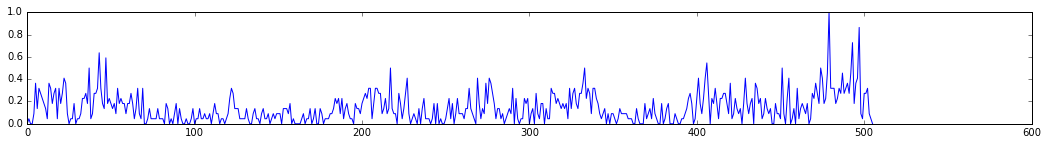

In [64]:
turbo = chat.loc[chat['turbo'] == True, ['emote_count', 'secondstamp', 'timestamp']]
turbo_freq = subs['secondstamp'].value_counts().sort_index().tolist()
turbo_norm = [(v-min(turbo_freq))/(max(turbo_freq)-min(turbo_freq)) for v in turbo_freq]
fig = plt.figure(figsize=(18,2))
plt.plot(turbo_norm)

ValueError: x and y must be the same size

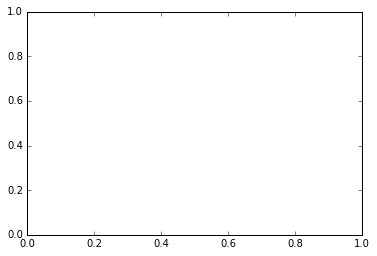

In [65]:
turbo = chat.loc[chat['turbo'] == True, ['emote_count', 'secondstamp', 'timestamp']]
turbo_freq = subs['secondstamp'].value_counts().sort_index().tolist()
turbo_norm = [(v-min(turbo_freq))/(max(turbo_freq)-min(turbo_freq)) for v in turbo_freq]
fig = plt.figure(figsize=(18,2))
plt.plot(turbo_norm)

In [39]:
x = chat.loc[chat['emote_count'] == 0, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist()
y = chat.loc[chat['emote_count'] == 1, ['emote_count', 'secondstamp', 'timestamp']]['secondstamp'].value_counts().sort_index().tolist()

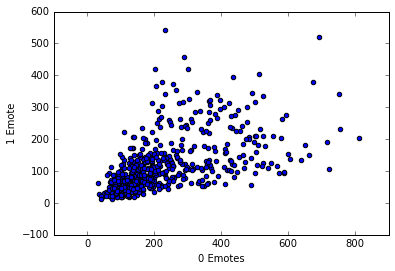

In [42]:
plt.scatter(x, y)
plt.xlabel('0 Emotes')
plt.ylabel('1 Emote')

In [37]:
no_emotes.head()

,emote_count,secondstamp,timestamp
1,0,0,240
3,0,0,853
5,0,0,1404
7,0,0,2318
9,0,0,2565


In [60]:
# With emotes
chat['frequency'].value_counts().sum()

545

In [34]:
# Without emotes
chat['frequency'].value_counts().sum()

545

In [83]:
status = pd.read_csv('/Users/Rich/Desktop/save.csv')

In [108]:
games = status['game'].value_counts().index.tolist()[1:]
highlights = pd.DataFrame()
highlights['second'] = status['second']
highlights['highlight'] = [0] * len(highlights.index)
for game in games:
    seconds = status[status['game'] == game]['second']
    start = seconds.min()
    stop = seconds.max()

    chat_segment = chat[(chat['secondstamp'] >= start) & (chat['secondstamp'] <= stop)]
    game_highs = chat_segment['secondstamp'].value_counts().sort_values(ascending=False).index[0:3].tolist()
    for i in game_highs:
        highlights.loc[highlights['second'] == i, 'highlight'] = 1
# highlights.head(100)

,second,highlight
0,0,0
1,60,0
2,120,0
3,180,0
4,240,0
5,300,0
6,360,0
7,420,0
8,480,0
9,540,0


In [85]:
chat.index.max()

226713